# Twitter US Airline Sentiment Analysis :

This project focuses on extracting and engineering meaningful features from raw Twitter data to support sentiment classification (positive, negative, neutral). We will:

- Preprocess the tweet text
- Extract numeric features such as word count, punctuation, and polarity
- Use TF-IDF vectors for richer representation
- Perform Exploratory Data Analysis (EDA)
- Identify which features correlate with sentiment classes

The dataset used is the Twitter US Airline Sentiment dataset.


### Step 1: Installing Required Libraries

Before importing, we need to install the necessary libraries. These will be used for:
- Data handling (pandas, numpy)
- Text processing (spaCy, TextBlob, etc.)
- Feature engineering and visualization

The following cell installs all required packages. If you're using Jupyter Notebook, run it with a `!` before each `pip install`.


In [5]:
# Run this cell in Jupyter Notebook to install all dependencies

!pip install pandas 
!pip install numpy 
!pip install matplotlib 
!pip install seaborn 
!pip install spacy 
!pip install textblob 
!pip install scikit-learn nltk

# Download required corpora for textblob and spaCy
!python -m textblob.download_corpora
!python -m spacy download en_core_web_sm


Finished.


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\LG\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\LG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LG\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\LG\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\LG\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\LG\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     - ------------------------------------- 0.5/12.8 MB 360.4 kB/s eta 0:00:35
     - ------------------------------------- 0.5/12.8 MB 360.4 kB/s eta 0:00:35
     - ------------------------------------- 0.5/12.8 MB 360.4 kB/s eta 0:00:35
     -- --------------------------------

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\LG\\AppData\\Local\\Temp\\pip-unpack-42rdpna6\\en_core_web_sm-3.8.0-py3-none-any.whl'
Consider using the `--user` option or check the permissions.



* now we have to import all the installed libraries 

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import spacy
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer


### Step 2: Load and Preview the Dataset

* We begin by importing the dataset using pandas.

* The dataset contains tweets related to US airlines and is labeled for sentiment analysis. We'll load it and take an initial look at its structure.


In [10]:
import pandas as pd
df = pd.read_csv("Tweets.csv")
df.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Step 4: Text Preprocessing

We clean the tweet text by performing the following:
- Convert text to lowercase
- Remove URLs, mentions, hashtags, and special characters
- Remove stopwords (common words like "the", "is", "and")
- Apply lemmatization using spaCy to reduce words to their base form (e.g., "flying" → "fly")
The cleaned text is stored in a new column called `clean_text`.


In [11]:
import spacy
import re
from spacy.lang.en.stop_words import STOP_WORDS

# Load spaCy's small English model
nlp = spacy.load("en_core_web_sm")

# Define a function to clean text
def clean_text(text):
    text = str(text).lower()                          # Lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove links
    text = re.sub(r'@\w+|#', '', text)                # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)           # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()          # Remove extra spaces

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in STOP_WORDS and not token.is_punct]
    return " ".join(tokens)

# Apply to the 'text' column
df['clean_text'] = df['text'].apply(clean_text)

# Show a sample
df[['text', 'clean_text']].head()


,text,clean_text
0,@VirginAmerica What @dhepburn said.,say
1,@VirginAmerica plus you've added commercials t...,plus ve add commercial experience tacky
2,@VirginAmerica I didn't today... Must mean I n...,not today mean need trip
3,@VirginAmerica it's really aggressive to blast...,aggressive blast obnoxious entertainment guest...
4,@VirginAmerica and it's a really big bad thing...,big bad thing


### Step 4: Feature Engineering

* We extract several useful numerical features from each tweet to help our model distinguish between different sentiments.

*  These include structural and sentiment-based features like word count, punctuation usage, and polarity score.


In [12]:
from textblob import TextBlob

# Word count
df['word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))

# Character count
df['char_count'] = df['clean_text'].apply(lambda x: len(str(x)))

# Average word length
df['avg_word_length'] = df['char_count'] / (df['word_count'] + 1)

# Number of exclamation marks
df['num_exclamations'] = df['text'].apply(lambda x: x.count('!'))

# Number of question marks
df['num_questions'] = df['text'].apply(lambda x: x.count('?'))

# Presence of hashtags
df['has_hashtag'] = df['text'].apply(lambda x: 1 if '#' in x else 0)

# Presence of mentions
df['has_mention'] = df['text'].apply(lambda x: 1 if '@' in x else 0)

# Polarity score using TextBlob
df['polarity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Show a few rows with new features
df[['clean_text', 'word_count', 'char_count', 'avg_word_length',
    'num_exclamations', 'num_questions', 'has_hashtag',
    'has_mention', 'polarity']].head()


,clean_text,word_count,char_count,avg_word_length,num_exclamations,num_questions,has_hashtag,has_mention,polarity
0,say,1,3,1.500000,0,0,0,1,0.0000
1,plus ve add commercial experience tacky,6,39,5.571429,0,0,0,1,0.0000
2,not today mean need trip,5,24,4.000000,1,0,0,1,-0.3125
3,aggressive blast obnoxious entertainment guest...,9,71,7.100000,0,0,0,1,-0.1875
4,big bad thing,3,13,3.250000,0,0,0,1,-0.3500


### Step 5: Exploratory Data Analysis (EDA)

* We now explore the relationships between extracted features and tweet sentiments.

*  This includes visualizing the distribution of sentiment classes and analyzing which features are most correlated with sentiment polarity.


C:\Users\LG\AppData\Local\Temp\ipykernel_17124\506030497.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='airline_sentiment', palette='coolwarm')


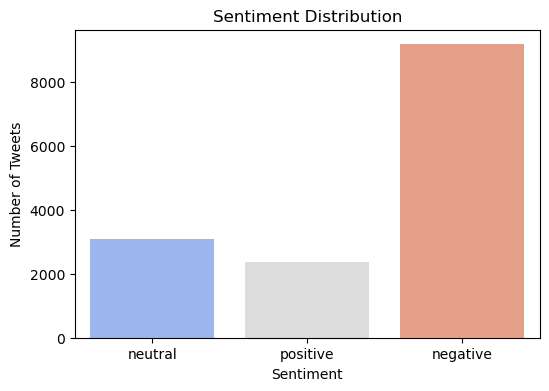

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='airline_sentiment', palette='coolwarm')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()


In [14]:
# Average values of features by sentiment
df.groupby('airline_sentiment')[['word_count', 'char_count', 'num_exclamations', 'num_questions', 'polarity']].mean()


,word_count,char_count,num_exclamations,num_questions,polarity
airline_sentiment,,,,,
negative,8.723360,54.067989,0.288734,0.345391,-0.031072
neutral,6.265247,38.626008,0.216199,0.448854,0.082145
positive,6.505290,40.459585,0.842996,0.049513,0.290534


C:\Users\LG\AppData\Local\Temp\ipykernel_17124\3419238977.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='airline_sentiment', y='polarity', palette='viridis')


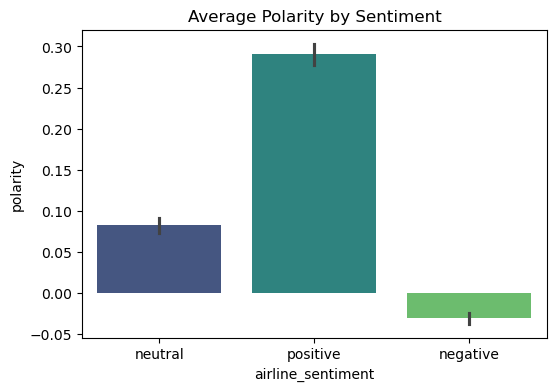

In [15]:
# Barplot of average polarity by sentiment
plt.figure(figsize=(6,4))
sns.barplot(data=df, x='airline_sentiment', y='polarity', palette='viridis')
plt.title('Average Polarity by Sentiment')
plt.show()


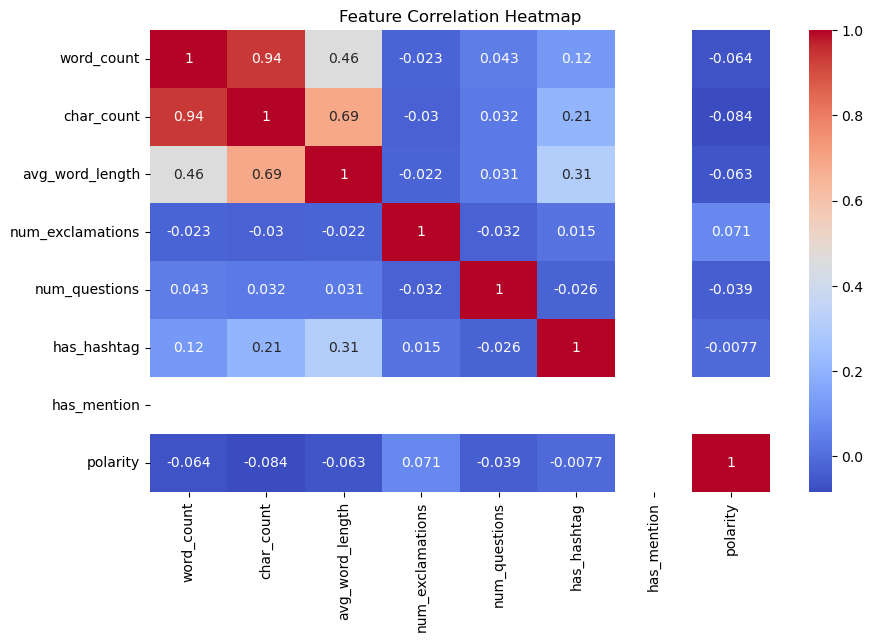

In [17]:
plt.figure(figsize=(10,6))
sns.heatmap(df[['word_count', 'char_count', 'avg_word_length', 'num_exclamations', 'num_questions', 'has_hashtag', 'has_mention', 'polarity']].corr(), 
            annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


# Conclusion

In this assignment, we successfully transformed a raw tweet dataset into a structured and informative format suitable for sentiment classification. The key steps included:

- **Data Loading & Previewing**: Loaded the Twitter US Airline Sentiment dataset.
- **Text Preprocessing**: Applied lowercase conversion, stopword removal, and lemmatization using spaCy.
- **Feature Engineering**: Extracted key numeric features such as word count, character count, punctuation usage, presence of mentions/hashtags, and sentiment polarity.
- **Exploratory Data Analysis (EDA)**: Visualized sentiment distribution and examined feature correlations with sentiment classes.

These extracted features can now be used to train machine learning models for sentiment classification. This process not only boosts model accuracy but also enhances interpretability.

---


